# 注意力评分函数



In [1]:
import sys
sys.path.append('..')

In [2]:
from d2l import mindspore as d2l
import math
import mindspore
from mindspore import nn

掩蔽softmax操作

In [3]:
def masked_softmax(X, valid_lens):
    """通过在最后一个轴上掩蔽元素来执行 softmax 操作"""
    # X:3D张量，valid_lens:1D或2D张量
    if valid_lens is None:
        return nn.Softmax(-1)(X)
    else:
        shape = X.shape
        if valid_lens.ndim == 1:
            valid_lens = d2l.repeat(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # 最后一轴上被掩蔽的元素使用一个非常大的负值替换，从而其softmax输出为0
        X = d2l.sequence_mask(X.reshape(-1, shape[-1]), valid_lens,
                              value=-1e6)
        return nn.Softmax(-1)(X.reshape(shape))

演示此函数是如何工作

In [4]:
masked_softmax(d2l.rand((2, 2, 4)), d2l.tensor([2, 3], mindspore.int32))

Tensor(shape=[2, 2, 4], dtype=Float32, value=
[[[ 3.28483313e-01,  6.71516716e-01,  0.00000000e+00,  0.00000000e+00],
  [ 4.44708079e-01,  5.55291951e-01,  0.00000000e+00,  0.00000000e+00]],
 [[ 2.75162101e-01,  4.66832906e-01,  2.58005083e-01,  0.00000000e+00],
  [ 3.29636276e-01,  3.50261986e-01,  3.20101738e-01,  0.00000000e+00]]])

In [5]:
masked_softmax(d2l.rand((2, 2, 4)), d2l.tensor([[1, 3], [2, 4]], mindspore.int32))

Tensor(shape=[2, 2, 4], dtype=Float32, value=
[[[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
  [ 3.22775692e-01,  3.86722207e-01,  2.90502131e-01,  0.00000000e+00]],
 [[ 3.08231175e-01,  6.91768825e-01,  0.00000000e+00,  0.00000000e+00],
  [ 2.92420477e-01,  1.94799751e-01,  2.19975904e-01,  2.92803943e-01]]])

加性注意力

In [6]:
class AdditiveAttention(nn.Cell):
    """加性注意力"""
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Dense(key_size, num_hiddens, has_bias=False)
        self.W_q = nn.Dense(query_size, num_hiddens, has_bias=False)
        self.w_v = nn.Dense(num_hiddens, 1, has_bias=False)
        self.dropout = nn.Dropout(1 - dropout)

    def construct(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # 在维度扩展后，
        # queries的形状：(batch_size，查询的个数，1，num_hidden)
        # key的形状：(batch_size，1，“键－值”对的个数，num_hiddens)
        # 使用广播方式进行求和
        features = d2l.expand_dims(queries, 2) + d2l.expand_dims(keys, 1)
        features = d2l.tanh(features)
        # self.w_v仅有一个输出，因此从形状中移除最后那个维度。
        # scores的形状：(batch_size，查询的个数，“键-值”对的个数)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # values的形状：(batch_size，“键－值”对的个数，值的维度)
        return d2l.bmm(self.dropout(self.attention_weights), values)

演示上面的`AdditiveAttention`类

In [7]:
queries, keys = d2l.normal((2, 1, 20), 0, 1), d2l.ones((2, 10, 2))
# values的小批量，两个值矩阵是相同的
values = d2l.tile(d2l.arange(40, dtype=mindspore.float32).reshape(1, 10, 4), (2, 1, 1))
valid_lens = d2l.tensor([2, 6])

attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8,
                              dropout=0.1)
attention.set_train(False)
attention(queries, keys, values, valid_lens)

Tensor(shape=[2, 1, 4], dtype=Float32, value=
[[[ 2.00000000e+00,  3.00000000e+00,  4.00000000e+00,  5.00000000e+00]],
 [[ 1.00000000e+01,  1.10000000e+01,  1.20000000e+01,  1.30000000e+01]]])

注意力权重

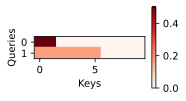

In [8]:
d2l.show_heatmaps(d2l.reshape(attention.attention_weights, (1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

缩放点积注意力

In [9]:
class DotProductAttention(nn.Cell):
    """缩放点积注意力"""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(1 - dropout)

    # queries的形状：(batch_size，查询的个数，d)
    # keys的形状：(batch_size，“键－值”对的个数，d)
    # values的形状：(batch_size，“键－值”对的个数，值的维度)
    # valid_lens的形状:(batch_size，)或者(batch_size，查询的个数)
    def construct(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # 设置transpose_b=True为了交换keys的最后两个维度
        scores = d2l.bmm(queries, keys.swapaxes(1,2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return d2l.bmm(self.dropout(self.attention_weights), values)

演示上述的`DotProductAttention`类

In [10]:
queries = d2l.normal((2, 1, 2), 0, 1)
attention = DotProductAttention(dropout=0.5)
attention.set_train(False)
attention(queries, keys, values, valid_lens)

Tensor(shape=[2, 1, 4], dtype=Float32, value=
[[[ 2.00000000e+00,  3.00000000e+00,  4.00000000e+00,  5.00000000e+00]],
 [[ 1.00000000e+01,  1.10000000e+01,  1.20000000e+01,  1.30000000e+01]]])

均匀的注意力权重

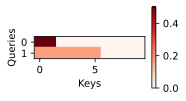

In [11]:
d2l.show_heatmaps(d2l.reshape(attention.attention_weights, (1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')